<a href="https://colab.research.google.com/github/DeniseGGarcia/Projetos/blob/main/Analise%20Global%20da%20Evolu%C3%A7%C3%A3o%20do%20Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Desafio Final: An√°lise Global da Evolu√ß√£o do C√¢ncer (2015‚Äì2024)

##**Objetivo:**
###Realizar uma an√°lise explorat√≥ria e preditiva para identificar padr√µes temporais, regionais e demogr√°ficos relacionados √† incid√™ncia de c√¢ncer no mundo, com foco em apoiar pol√≠ticas p√∫blicas de preven√ß√£o. Dica: usar como target a coluna Target_Severity_Score.

### **Dicion√°rio de Vari√°veis:**

* **Patient_ID** - Identificador √∫nico do paciente

* **Age** - Idade

* **Gender** - G√™nero

* **Country_Region** - Pa√≠s/Regi√£o

* **Year** - Ano do registro

* **Genetic_Risk** - Risco gen√©tico (0-100)

* **Air_Pollution** - Exposi√ß√£o √† polui√ß√£o do ar (0-100)

* **Alcohol_Use** - Consumo de √°lcool (0-100)

* **Smoking** - Tabagismo (0-100)

* **Obesity_Level** - Obesidade (0-100)

* **Cancer_Type** - Tipo de c√¢ncer

* **Cancer_Stage** - Est√°gio do c√¢ncer

* **Treatment_Cost_USD** - Custo do tratamento (USD)

* **Survival_Years** - Anos de sobrevida

* **Target_Severity_Score** - Score de severidade (target preditivo)

## Importa√ß√µes:

In [ ]:
# Importa√ß√µes
!pip install xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

# Montando o Drive para carregar o arquivo
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

file_id = "1Mu7Z1TFQCzfoO8iL5olnmGB1RtZwr2CY"

url = f"https://drive.google.com/uc?id={file_id}&export=download"

df = pd.read_csv(url)

df.head()

Mounted at /content/drive


Patient_ID  Age  Gender Country_Region  Year  Genetic_Risk  Air_Pollution  \
0  PT0000000   71    Male             UK  2021           6.4            2.8   
1  PT0000001   34    Male          China  2021           1.3            4.5   
2  PT0000002   80    Male       Pakistan  2023           7.4            7.9   
3  PT0000003   40    Male             UK  2015           1.7            2.9   
4  PT0000004   43  Female         Brazil  2017           5.1            2.8   

   Alcohol_Use  Smoking  Obesity_Level Cancer_Type Cancer_Stage  \
0          9.5      0.9            8.7        Lung    Stage III   
1          3.7      3.9            6.3    Leukemia      Stage 0   
2          2.4      4.7            0.1      Breast     Stage II   
3          4.8      3.5            2.7       Colon      Stage I   
4          2.3      6.7            0.5        Skin    Stage III   

   Treatment_Cost_USD  Survival_Years  Target_Severity_Score  
0            62913.44             5.9                   4.92  
1            12573.41             4.7                   4.65  
2             6984.33             7.1                   5.84  
3            67446.25             1.6                   3.12  
4            77977.12             2.9                   3.62

## Vis√£o geral do dataset e suas estat√≠sticas:

In [ ]:
# Vis√£o geral do df
print("\nInforma√ß√µes do dataset:")
df.info()


Informa√ß√µes do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Patient_ID             50000 non-null  object 
 1   Age                    50000 non-null  int64  
 2   Gender                 50000 non-null  object 
 3   Country_Region         50000 non-null  object 
 4   Year                   50000 non-null  int64  
 5   Genetic_Risk           50000 non-null  float64
 6   Air_Pollution          50000 non-null  float64
 7   Alcohol_Use            50000 non-null  float64
 8   Smoking                50000 non-null  float64
 9   Obesity_Level          50000 non-null  float64
 10  Cancer_Type            50000 non-null  object 
 11  Cancer_Stage           50000 non-null  object 
 12  Treatment_Cost_USD     50000 non-null  float64
 13  Survival_Years         50000 non-null  float64
 14  Target_Severity_Score  5000

In [ ]:
df.shape

(50000, 15)

In [ ]:
# Estat√≠sticas gerais dos dados num√©ricos
print("\nEstat√≠sticas descritivas dos dados num√©ricos:")
df.describe()


Estat√≠sticas descritivas dos dados num√©ricos:


Age          Year  Genetic_Risk  Air_Pollution   Alcohol_Use  \
count  50000.000000  50000.000000  50000.000000   50000.000000  50000.000000   
mean      54.421540   2019.480520      5.001698       5.010126      5.010880   
std       20.224451      2.871485      2.885773       2.888399      2.888769   
min       20.000000   2015.000000      0.000000       0.000000      0.000000   
25%       37.000000   2017.000000      2.500000       2.500000      2.500000   
50%       54.000000   2019.000000      5.000000       5.000000      5.000000   
75%       72.000000   2022.000000      7.500000       7.500000      7.500000   
max       89.000000   2024.000000     10.000000      10.000000     10.000000   

            Smoking  Obesity_Level  Treatment_Cost_USD  Survival_Years  \
count  50000.000000   50000.000000        50000.000000    50000.000000   
mean       4.989826       4.991176        52467.298239        5.006462   
std        2.881579       2.894504        27363.229379        2.883335   
min        0.000000       0.000000         5000.050000        0.000000   
25%        2.500000       2.500000        28686.225000        2.500000   
50%        5.000000       5.000000        52474.310000        5.000000   
75%        7.500000       7.500000        76232.720000        7.500000   
max       10.000000      10.000000        99999.840000       10.000000   

       Target_Severity_Score  
count           50000.000000  
mean                4.951207  
std                 1.199677  
min                 0.900000  
25%                 4.120000  
50%                 4.950000  
75%                 5.780000  
max                 9.160000

In [ ]:
# Estat√≠sticas gerais dos dados categ√≥ricos
print("\nEstat√≠sticas descritivas dos dados categ√≥ricos:")
df.describe(include='object')


Estat√≠sticas descritivas dos dados categ√≥ricos:


Patient_ID Gender Country_Region Cancer_Type Cancer_Stage
count       50000  50000          50000       50000        50000
unique      50000      3             10           8            5
top     PT0049983   Male      Australia       Colon     Stage II
freq            1  16796           5092        6376        10124

##Limpeza dos dados:

In [ ]:
# Valores b√°sicos do n√∫mero pro genero
df['Gender'].value_counts()

Gender
Male      16796
Female    16709
Other     16495
Name: count, dtype: int64

Verificamos valores incoerentes, como Homem com Cancer Cervical/Mama (Cancer de Mama em Homens ocorre de 0,5 a 1%) [fonte: https://www.who.int/news-room/fact-sheets/detail/breast-cancer.) e Mulheres com Cancer de Prostata.

In [ ]:
# Verificando a contagem de dados incoerentes
invalido = (
    ((df['Gender'] == 'Female') & (df['Cancer_Type'].str.contains('prostate', case=False, na=False))) |
    ((df['Gender'] == 'Male') & (df['Cancer_Type'].str.contains('cervical|breast', case=False, na=False)))
)

print(f"Linhas inv√°lidas encontradas: {invalido.sum()}")

Linhas inv√°lidas encontradas: 6221


In [ ]:
# Separar casos incoerentes (Female-Prostate e Male-Cervical)
cond_incoerente = (
    ((df['Gender'] == 'Female') & (df['Cancer_Type'].str.contains('prostate', case=False, na=False))) |
    ((df['Gender'] == 'Male') & (df['Cancer_Type'].str.contains('cervical', case=False, na=False)))
)

# Separar casos Male-Breast
cond_male_breast = (
    (df['Gender'] == 'Male') &
    (df['Cancer_Type'].str.contains('breast', case=False, na=False))
)

# Amostrar 1% dos casos Male-Breast - com seed para reprodutibilidade
male_breast_1pct = df[cond_male_breast].sample(frac=0.01, random_state=42)

# Manter:
# - Todos os dados v√°lidos (n√£o incoerentes e n√£o Male-Breast)
# - + 1% amostrado de Male-Breast
df_cancer = pd.concat([
    df[~cond_incoerente & ~cond_male_breast],
    male_breast_1pct
], ignore_index=True)

# Resetar index e exibir quantidade de linhas ap√≥s a limpeza
df_cancer = df_cancer.reset_index(drop=True)
print(f"N√∫mero final de linhas ap√≥s limpeza: {df_cancer.shape[0]}")

N√∫mero final de linhas ap√≥s limpeza: 43800


In [ ]:
# Estat√≠sticas gerais dos dados num√©ricos ap√≥s limpeza
print("\nEstat√≠sticas descritivas dos dados num√©ricos ap√≥s limpeza dos dados:")
df_cancer.describe()


Estat√≠sticas descritivas dos dados num√©ricos ap√≥s limpeza dos dados:


Age          Year  Genetic_Risk  Air_Pollution   Alcohol_Use  \
count  43800.000000  43800.000000  43800.000000   43800.000000  43800.000000   
mean      54.417968   2019.485708      5.005692       5.015527      5.007534   
std       20.227674      2.873836      2.888920       2.889128      2.886004   
min       20.000000   2015.000000      0.000000       0.000000      0.000000   
25%       37.000000   2017.000000      2.500000       2.500000      2.500000   
50%       54.000000   2019.000000      5.000000       5.000000      5.000000   
75%       72.000000   2022.000000      7.500000       7.500000      7.500000   
max       89.000000   2024.000000     10.000000      10.000000     10.000000   

            Smoking  Obesity_Level  Treatment_Cost_USD  Survival_Years  \
count  43800.000000   43800.000000        43800.000000    43800.000000   
mean       4.988331       4.990932        52493.272190        5.003550   
std        2.882519       2.896902        27380.706998        2.882144   
min        0.000000       0.000000         5000.050000        0.000000   
25%        2.500000       2.500000        28674.577500        2.500000   
50%        5.000000       5.000000        52494.820000        5.000000   
75%        7.500000       7.500000        76295.290000        7.500000   
max       10.000000      10.000000        99999.840000       10.000000   

       Target_Severity_Score  
count           43800.000000  
mean                4.951482  
std                 1.200088  
min                 0.900000  
25%                 4.120000  
50%                 4.950000  
75%                 5.790000  
max                 9.160000

In [ ]:
# Estat√≠sticas gerais dos dados categ√≥ricos ap√≥s limpeza
print("\nEstat√≠sticas descritivas dos dados categ√≥ricos ap√≥s limpeza dos dados:")
df_cancer.describe(include='object')


Estat√≠sticas descritivas dos dados categ√≥ricos ap√≥s limpeza dos dados:


Patient_ID Gender Country_Region Cancer_Type Cancer_Stage
count       43800  43800          43800       43800        43800
unique      43800      3             10           8            5
top     PT0041333  Other      Australia       Colon     Stage II
freq            1  16495           4496        6376         8882

## An√°lise da distribui√ß√£o dos dados num√©ricos:

In [ ]:
# Selecionar colunas num√©ricas
num_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()

# Excluir Patient_ID (que √© object e n√£o estar√° na lista)
if "Patient_ID" in num_cols:
    num_cols.remove("Patient_ID")

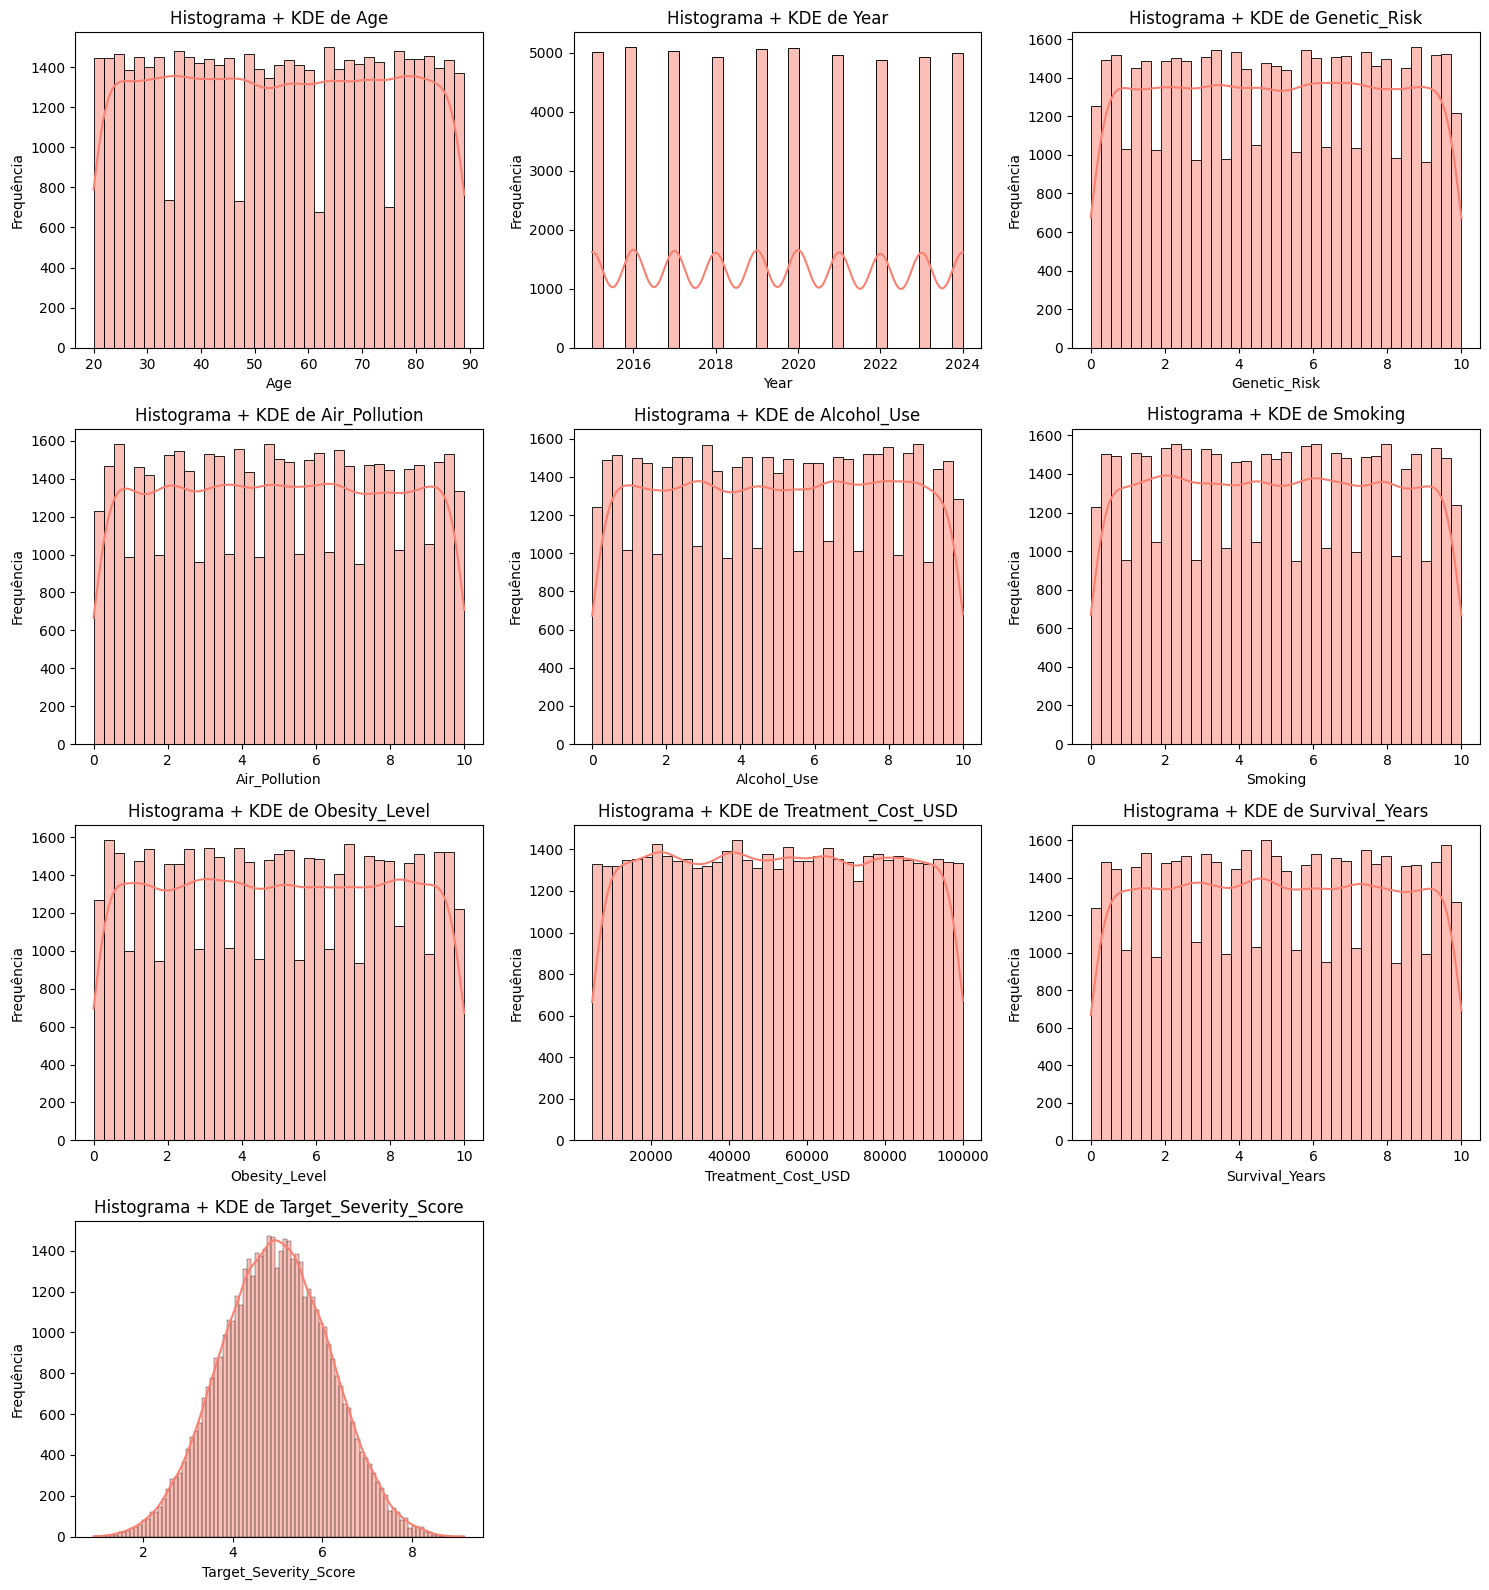

In [ ]:
# Suponha que num_cols seja sua lista de colunas num√©ricas
num_cols = df_cancer.select_dtypes(include='number').columns.tolist()

# N√∫mero de linhas e colunas no grid
n_cols = 3
n_rows = -(-len(num_cols) // n_cols)  # arredondamento para cima

# Criar os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# Plotar histograma + KDE para cada coluna num√©rica
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color="salmon")
    axes[i].set_title(f"Histograma + KDE de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequ√™ncia")

# Remover subplots vazios
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


##Poss√≠veis Outliers:

In [ ]:
# Selecionar colunas num√©ricas
num_cols = ['Age', 'Treatment_Cost_USD', 'Survival_Years']
z_scores = df_cancer[num_cols].apply(zscore)

# Filtra linhas com pelo menos um z-score acima de 3 ou abaixo de -3
outliers = df_cancer[(abs(z_scores) > 3).any(axis=1)]

print(f"N√∫mero de poss√≠veis outliers: {len(outliers)}")

N√∫mero de poss√≠veis outliers: 0


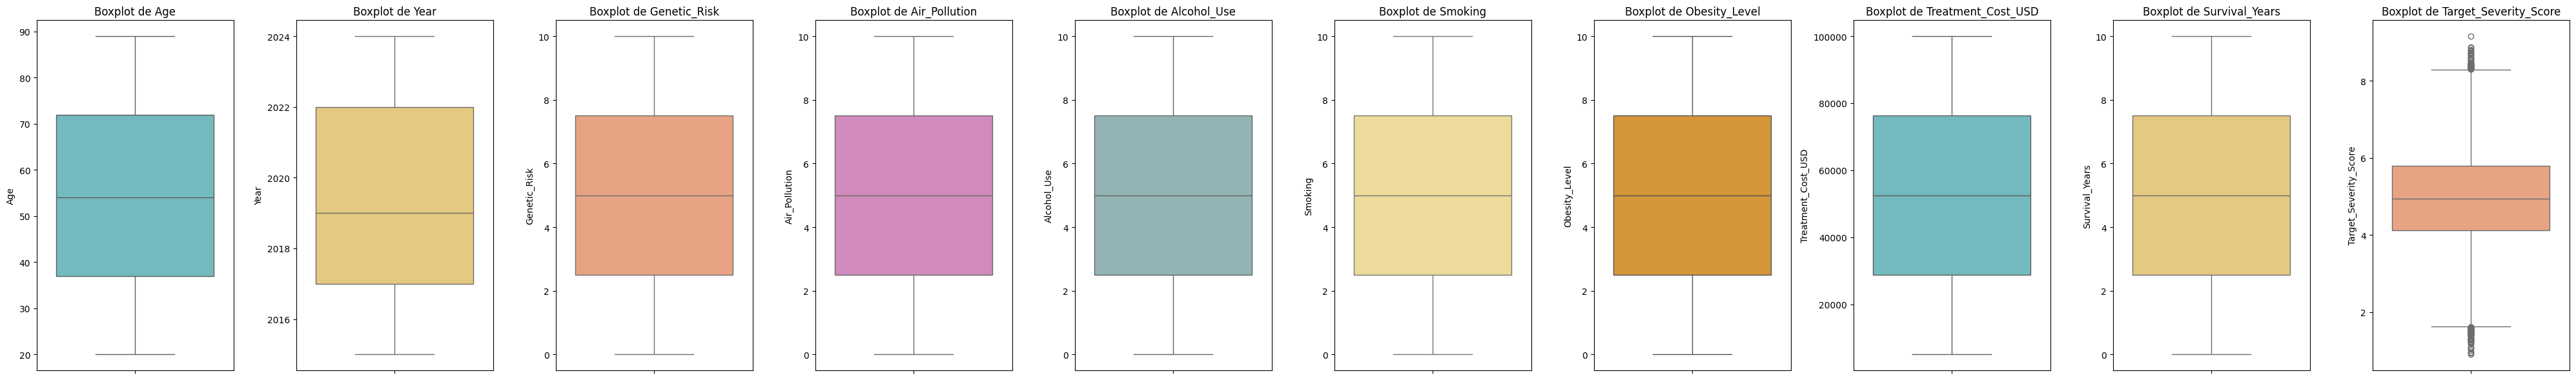

In [ ]:
# Seleciona as colunas num√©ricas
num_cols = df_cancer.select_dtypes(include=['number']).columns

# Paleta pastel
cores_pastel = ['#66c5cc', '#f6cf71', '#f89c74', '#dc7ec0', '#8eb9b9', '#fae38c', '#ef9b20']
cores_usadas = (cores_pastel * ((len(num_cols) // len(cores_pastel)) + 1))[:len(num_cols)]

# Define o tamanho da figura
plt.figure(figsize=(len(num_cols) * 4, 6))

# Cria um boxplot para cada coluna num√©rica com cor pastel
for i, (col, cor) in enumerate(zip(num_cols, cores_usadas), 1):
    plt.subplot(1, len(num_cols), i)
    sns.boxplot(y=df_cancer[col], color=cor)
    plt.title(f'Boxplot de {col}')
    plt.tight_layout()

plt.show()

##Identificar os pa√≠ses com maior n√∫mero de casos:

In [ ]:
#Contagem de casos por pa√≠s

casos_por_pais = df_cancer['Country_Region'].value_counts()

pais_mais_casos = casos_por_pais.idxmax()
qtd_mais_casos = casos_por_pais.max()

print(f"O pa√≠s com mais casos √©: {pais_mais_casos} ({qtd_mais_casos} casos)")

O pa√≠s com mais casos √©: Australia (4496 casos)


In [ ]:
# Contar os casos por pa√≠s ‚Äî forma mais robusta
cases_by_country = (
    df_cancer.groupby("Country_Region")
    .size()
    .reset_index(name="Case_Count")
    .sort_values(by="Case_Count", ascending=False)
)

# Plotar com Plotly com r√≥tulos
fig = px.bar(
    cases_by_country,
    x="Case_Count",
    y="Country_Region",
    orientation="h",
    title="N√∫mero de Casos por Pa√≠s (2015‚Äì2024)",
    color="Country_Region",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    text="Case_Count"
)

# Define a posi√ß√£o dos r√≥tulos
fig.update_traces(
    textposition="outside"
)

# Define o range dinamicamente
min_val = cases_by_country["Case_Count"].min()
max_val = cases_by_country["Case_Count"].max()

# Layout final
fig.update_layout(
    xaxis=dict(
        title="N√∫mero de Casos",
        range=[min_val - 100, max_val + 100]
    ),
    yaxis_title="Pa√≠s",
    height=500,
    showlegend=False
)

fig.show()


##Avaliar evolu√ß√£o temporal (2015‚Äì2024) da incid√™ncia:

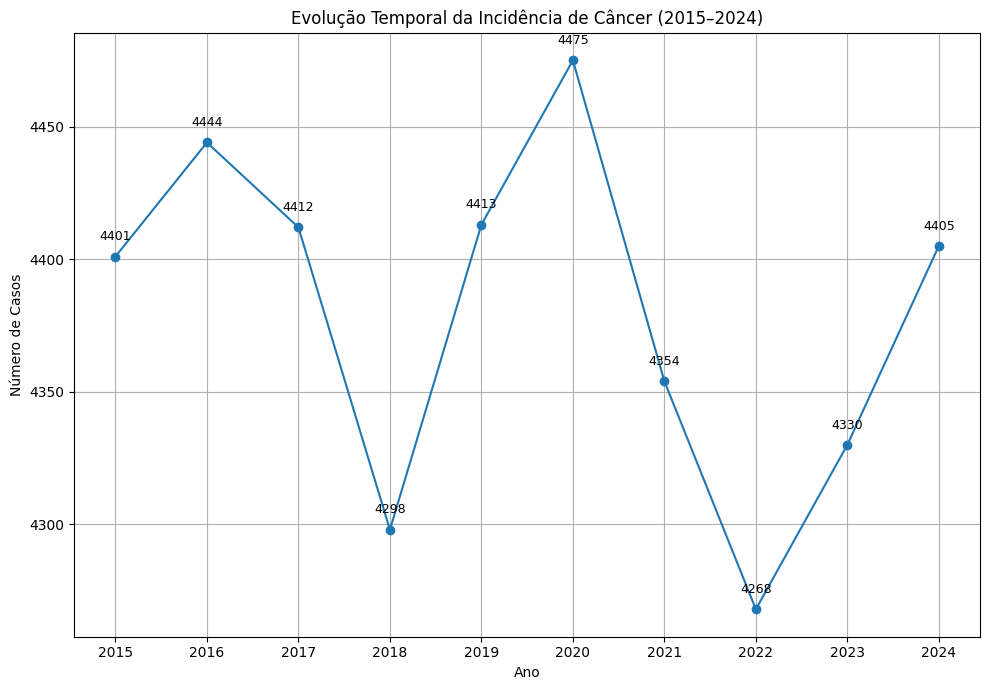

In [ ]:
#Filtrando ano de interesse 2015 a 2024

df_filtrado = df_cancer[(df_cancer['Year'] >= 2015) & (df_cancer['Year'] <= 2024)]
casos_por_ano = df_filtrado['Year'].value_counts().sort_index()

ax = casos_por_ano.plot(
    kind='line',
    marker='o',
    figsize=(10,7),
    title='Evolu√ß√£o Temporal da Incid√™ncia de C√¢ncer (2015‚Äì2024)'
)

plt.xlabel('Ano')
plt.ylabel('N√∫mero de Casos')
plt.grid(True)
plt.xticks(range(2015, 2025))
plt.tight_layout()

# Adiciona r√≥tulos em cada ponto da linha
for x, y in casos_por_ano.items():
    ax.text(x, y + 5, str(y), ha='center', va='bottom', fontsize=9)

plt.show()

##Analisar diferen√ßas por g√™nero, idade ou tipo de c√¢ncer:





###G√™nero

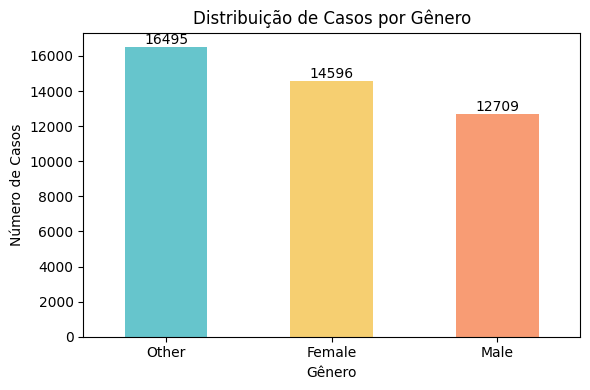

In [ ]:
# Quantidade de casos por g√™nero
casos_por_genero = df_cancer['Gender'].value_counts()

cores_hex = ['#66c5cc', '#f6cf71', '#f89c74', '#dc7ec0', '#8eb9b9', '#fae38c', '#ef9b20']

# Pega apenas as cores necess√°rias
cores_usadas = cores_hex[:len(casos_por_genero)]

# Plot
ax = casos_por_genero.plot(
    kind='bar',
    title='Distribui√ß√£o de Casos por G√™nero',
    figsize=(6, 4),
    color=cores_usadas
)

plt.xlabel('G√™nero')
plt.ylabel('N√∫mero de Casos')
plt.xticks(rotation=0)
plt.tight_layout()

# Adiciona r√≥tulos acima das barras
for i, v in enumerate(casos_por_genero):
    ax.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()


In [ ]:
# Distribui√ß√£o dos casos por g√™nero em gr√°fico de pizza
colors = ['#f89c74', "#f6cf71", '#66c5cc']

fig = px.pie(
    names=casos_por_genero.index,
    values=casos_por_genero.values,
    title="Distribui√ß√£o de Casos por G√™nero",
    color=casos_por_genero.index,
    color_discrete_map={
        "Male": colors[0],
        "Female": colors[1],
        "Other": colors[2]
    },
    hole=0.4
)

fig.update_traces(textinfo="percent+label", textfont_size=14)

fig.show()

In [ ]:
# Heatmap
# Paleta pastel convertida para cont√≠nuo
pastel_continuous = [
    [0.0, '#66c5cc'],
    [0.16, '#f6cf71'],
    [0.32, '#f89c74'],
    [0.48, '#dc7ec0'],
    [0.64, '#8eb9b9'],
    [0.80, '#fae38c'],
    [1.0, '#ef9b20']
]

# Cria√ß√£o da faixa et√°ria
bins = [20, 30, 40, 50, 60, 70, 80, 90]
labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89']
df_cancer['Age_Range'] = pd.cut(df_cancer['Age'], bins=bins, labels=labels, right=False)

# Agrupamento
gender_age_type_group = df_cancer[['Patient_ID', 'Gender', 'Age_Range', 'Cancer_Type']]\
    .groupby(['Gender', 'Age_Range', 'Cancer_Type'], observed=False).count()\
    .rename(columns={'Patient_ID': 'Total_Patients'})\
    .reset_index()

# Gr√°fico
fig = px.density_heatmap(
    gender_age_type_group,
    x='Age_Range',
    y='Cancer_Type',
    z='Total_Patients',
    facet_col='Gender',
    color_continuous_scale=pastel_continuous,
    title='Heatmap de Pacientes por G√™nero, Faixa Et√°ria e Tipo de C√¢ncer'
)

fig.update_layout(
    width=1100,
    height=500
)

fig.show()


In [ ]:
# Teste ANOVA para responder: A m√©dia da severidade √© diferente entre os g√™neros?
# Separar os grupos por g√™nero
grupo_m = df_cancer[df_cancer['Gender'] == 'Male']['Target_Severity_Score']
grupo_f = df_cancer[df_cancer['Gender'] == 'Female']['Target_Severity_Score']
grupo_o = df_cancer[df_cancer['Gender'] == 'Other']['Target_Severity_Score']

# Teste ANOVA
stat, p = f_oneway(grupo_m, grupo_f, grupo_o)

print(f'Estat√≠stica F: {stat:.3f}')
print(f'Valor-p: {p:.4f}')

if p < 0.05:
    print('‚úÖ Diferen√ßa estat√≠stica significativa entre os g√™neros.')
else:
    print('üîç N√£o h√° diferen√ßa estat√≠stica significativa entre os g√™neros.')

Estat√≠stica F: 1.172
Valor-p: 0.3097
üîç N√£o h√° diferen√ßa estat√≠stica significativa entre os g√™neros.


###Idade

In [ ]:
#Criando faixas de idade

bins = [0, 18, 30, 45, 60, 75, 100]
labels = ['0-18', '19-30', '31-45', '46-60', '61-75', '76+']
df_cancer['Faixa_Etaria'] = pd.cut(df_cancer['Age'], bins=bins, labels=labels, right=False)

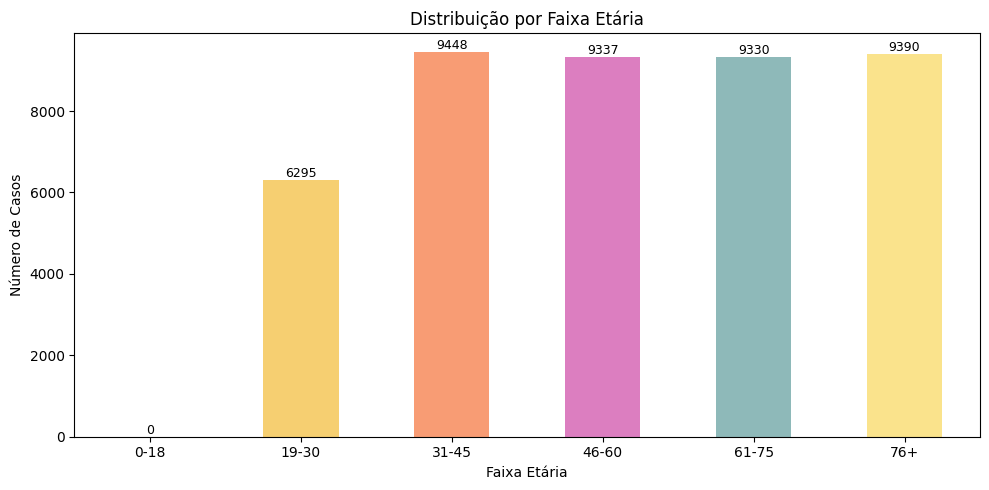

In [ ]:
# Dados
casos_por_idade = df_cancer['Faixa_Etaria'].value_counts().sort_index()

# Paleta pastel em hexadecimal
cores_pastel = ['#66c5cc', '#f6cf71', '#f89c74', '#dc7ec0', '#8eb9b9', '#fae38c', '#ef9b20']
cores_usadas = cores_pastel[:len(casos_por_idade)]

# Plot
ax = casos_por_idade.plot(
    kind='bar',
    title='Distribui√ß√£o por Faixa Et√°ria',
    figsize=(10, 5),
    color=cores_usadas
)

plt.xlabel('Faixa Et√°ria')
plt.ylabel('N√∫mero de Casos')
plt.xticks(rotation=0)
plt.tight_layout()

# R√≥tulos nas barras
for i, v in enumerate(casos_por_idade):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=9)

plt.show()

###Tipo de c√¢ncer

In [ ]:
# Agrupar e calcular a m√©dia de severidade por tipo de c√¢ncer
media_tipo_cancer = df_cancer.groupby('Cancer_Type')['Target_Severity_Score'].mean().reset_index()

# Gr√°fico de barras
fig = px.bar(
    media_tipo_cancer,
    x='Cancer_Type',
    y='Target_Severity_Score',
    title='M√©dia da Severidade por Tipo de C√¢ncer',
    labels={
        'Cancer_Type': 'Tipo de C√¢ncer',
        'Target_Severity_Score': 'M√©dia da Severidade'
    },
    color='Cancer_Type',
    text_auto='.4s',
    color_discrete_sequence=px.colors.qualitative.Set3
)

# Adiciona r√≥tulos com os valores arredondados
fig.update_traces(
    text=media_tipo_cancer['Target_Severity_Score'],
    textposition='outside'
)

# Layout final
fig.update_layout(
    template='plotly_white',
    showlegend=False,
    yaxis = {'type': 'log'}, # Neste caso utilizamos o 'log', pois os valores s√£o t√£o pr√≥ximos que n√£o √© poss√≠vel enxergar as diferen√ßas sem utiliz√°-lo
    xaxis_tickangle=-45
)

fig.show()

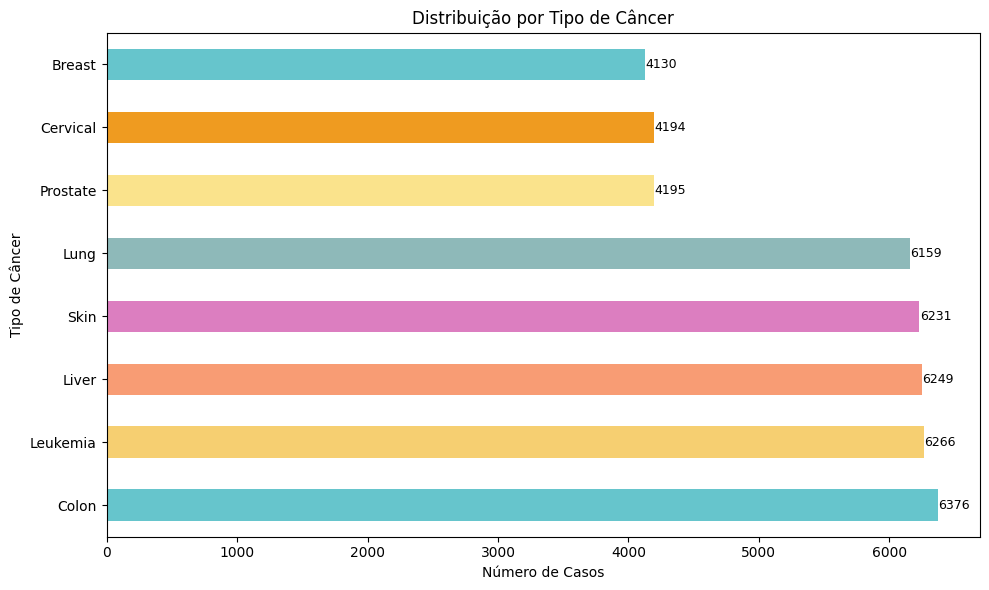

In [ ]:
# Distribui√ß√£o de casos por tipo de cancer
casos_por_tipo = df_cancer['Cancer_Type'].value_counts()

# Paleta pastel
cores_pastel = ['#66c5cc', '#f6cf71', '#f89c74', '#dc7ec0', '#8eb9b9', '#fae38c', '#ef9b20']
cores_usadas = (cores_pastel * ((len(casos_por_tipo) // len(cores_pastel)) + 1))[:len(casos_por_tipo)]

# Plot horizontal
ax = casos_por_tipo.plot(
    kind='barh',
    figsize=(10, 6),
    title='Distribui√ß√£o por Tipo de C√¢ncer',
    color=cores_usadas
)

plt.xlabel('N√∫mero de Casos')
plt.ylabel('Tipo de C√¢ncer')

# Adiciona os r√≥tulos nas barras
for i, v in enumerate(casos_por_tipo):
    ax.text(v + 1, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.show()


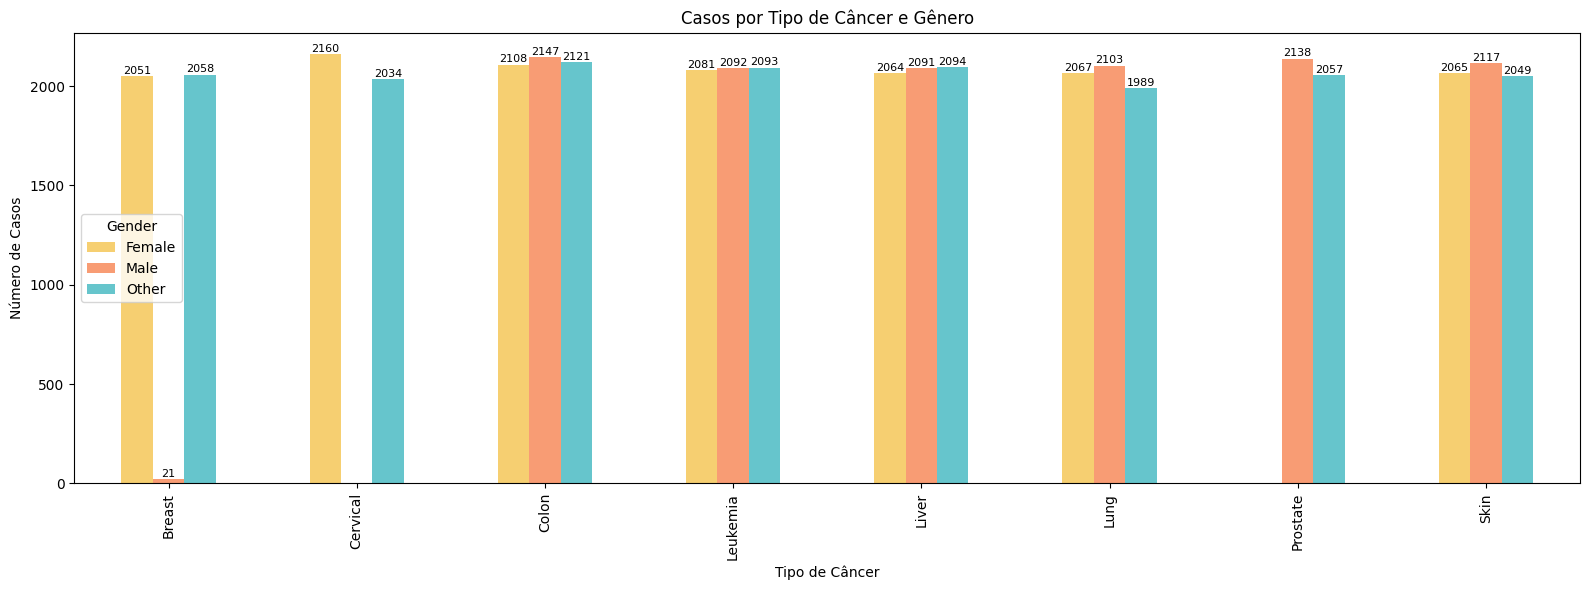

In [ ]:
# Distribui√ß√£o dos casos de c√¢ncer por tipo e g√™nero
genero_tipo = df_cancer.groupby(['Gender', 'Cancer_Type']).size().unstack().fillna(0)

# Paleta pastel
cores_pastel = ['#f6cf71', '#f89c74','#66c5cc']

# Plot
ax = genero_tipo.T.plot(
    kind='bar',
    figsize=(16, 6),
    title='Casos por Tipo de C√¢ncer e G√™nero',
    color=cores_pastel
)

plt.ylabel('N√∫mero de Casos')
plt.xlabel('Tipo de C√¢ncer')
plt.tight_layout()

# R√≥tulos nas barras
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + 1,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontsize=8
        )

plt.show()

In [ ]:
#Propor√ß√£o de cada g√™nero por tipo de c√¢ncer

# Contagem por tipo de c√¢ncer e g√™nero
contagem = df_cancer.groupby(['Cancer_Type', 'Gender']).size().reset_index(name='casos')

# Calcular propor√ß√£o de cada g√™nero dentro de cada tipo de c√¢ncer
total_por_tipo = contagem.groupby('Cancer_Type')['casos'].transform('sum')
contagem['proporcao'] = contagem['casos'] / total_por_tipo * 100

# Gr√°fico de barras empilhadas normalizadas
fig = px.bar(
    contagem,
    x='Cancer_Type',
    y='proporcao',
    color='Gender',
    title='Propor√ß√£o de G√™neros por Tipo de C√¢ncer (%)',
    labels={'proporcao': 'Propor√ß√£o (%)', 'Cancer_Type': 'Tipo de C√¢ncer'},
    text=contagem['proporcao'].round(1).astype(str) + '%',
    color_discrete_map={'Male': '#f89c74',
                        'Female': '#f6cf71',
                        'Other': '#66c5cc'
                        }
)

fig.update_layout(
    barmode='stack',
    template='plotly_white',
    xaxis_tickangle=-45
)
fig.show()

In [ ]:
# Transforma os dados para formato de matriz
# Agrupar por g√™nero e ano
df_genero_ano = df_cancer.groupby(['Gender', 'Year'])['Target_Severity_Score'].mean().reset_index()
heatmap_df = df_genero_ano.pivot(index='Gender', columns='Year', values='Target_Severity_Score')

# Cria o heatmap
fig = px.imshow(
    heatmap_df,
    labels=dict(x="Ano", y="G√™nero", color="Severidade"),
    title="Mapa de Calor da Severidade por G√™nero e Ano",
    color_continuous_scale='Reds',
    aspect="auto"
)

fig.show()

###Mapa de calor global com incid√™ncia por pa√≠s e ano

In [ ]:
# Agrupar dados por pa√≠s e ano (contagem de casos)
incidencia = df_cancer.groupby(['Country_Region', 'Year']).size().reset_index(name='Casos')

fig = px.choropleth(
    incidencia,
    locations='Country_Region',
    locationmode='country names',
    color='Casos',
    hover_name='Country_Region',
    animation_frame='Year',
    color_continuous_scale='Reds',
    title='Incid√™ncia de C√¢ncer por Pa√≠s e Ano'
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    coloraxis_colorbar=dict(title='N√∫mero de Casos')
)

fig.show()


In [ ]:
# S√©rie temporal para contar n√∫mero de casos por pa√≠s e ano
casos_por_pais_ano = df_cancer.groupby(['Country_Region', 'Year']).size().reset_index(name='numero_de_casos')

# Descobrir os 5 pa√≠ses com mais casos no total
top5_paises = df_cancer['Country_Region'].value_counts().head(5).index.tolist()

# Filtrar apenas os top 5 pa√≠ses
casos_top5 = casos_por_pais_ano[casos_por_pais_ano['Country_Region'].isin(top5_paises)]

# Criar gr√°fico de linha
fig = px.line(
    casos_top5,
    x='Year',
    y='numero_de_casos',
    color='Country_Region',
    markers=True,
    title='S√©rie Temporal da Incid√™ncia de C√¢ncer nos 5 Pa√≠ses com Mais Casos',
    labels={
        'Year': 'Ano',
        'numero_de_casos': 'N√∫mero de Casos',
        'Country_Region': 'Pa√≠s'
    }
)

fig.update_layout(template='plotly_white')
fig.show()

In [ ]:
# Agrupar por pa√≠s e ano, calculando a severidade m√©dia
df_pais = df_cancer.groupby(['Country_Region', 'Year'])['Target_Severity_Score'].mean().reset_index()

# Pivot para formato de mapa de calor
heatmap_data = df_pais.pivot(index='Country_Region', columns='Year', values='Target_Severity_Score')

# Plotar heatmap com Plotly
import plotly.express as px

fig = px.imshow(
    heatmap_data,
    labels=dict(x="Ano", y="Pa√≠s", color="Severidade"),
    title="Mapa de Calor da Severidade do C√¢ncer por Pa√≠s e Ano",
    color_continuous_scale='Reds'
)
fig.show()

### Comparativo entre Homens, Mulheres e Outros

In [ ]:
# Agrupar por pa√≠s, ano e g√™nero
casos = df_cancer.groupby(['Country_Region', 'Year', 'Gender']).size().reset_index(name='numero_de_casos')

# Identificar os 3 pa√≠ses com mais casos no total
top3_paises = df_cancer['Country_Region'].value_counts().head(3).index.tolist()

# Filtrar os dados para esses pa√≠ses
casos_top3 = casos[casos['Country_Region'].isin(top3_paises)]

# Definir paleta personalizada
paleta_cores = ['#f6cf71', '#f89c74', '#66c5cc']

# Criar gr√°fico de linhas
fig = px.line(
    casos_top3,
    x='Year',
    y='numero_de_casos',
    color='Gender',
    facet_col='Country_Region',
    facet_col_wrap=3,
    markers=True,
    text='numero_de_casos',
    title='S√©rie Temporal da Incid√™ncia de C√¢ncer por G√™nero (Top 3 Pa√≠ses)',
    labels={
        'Year': 'Ano',
        'numero_de_casos': 'N√∫mero de Casos',
        'Gender': 'G√™nero',
        'Country_Region': 'Pa√≠s'
    },
    color_discrete_sequence=paleta_cores
)

fig.update_layout(template='plotly_white')

# Ajustar posi√ß√£o dos r√≥tulos nas linhas
fig.update_traces(textposition='bottom center')

# Remover prefixo "Country_Region=" dos t√≠tulos dos facetes
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.show()



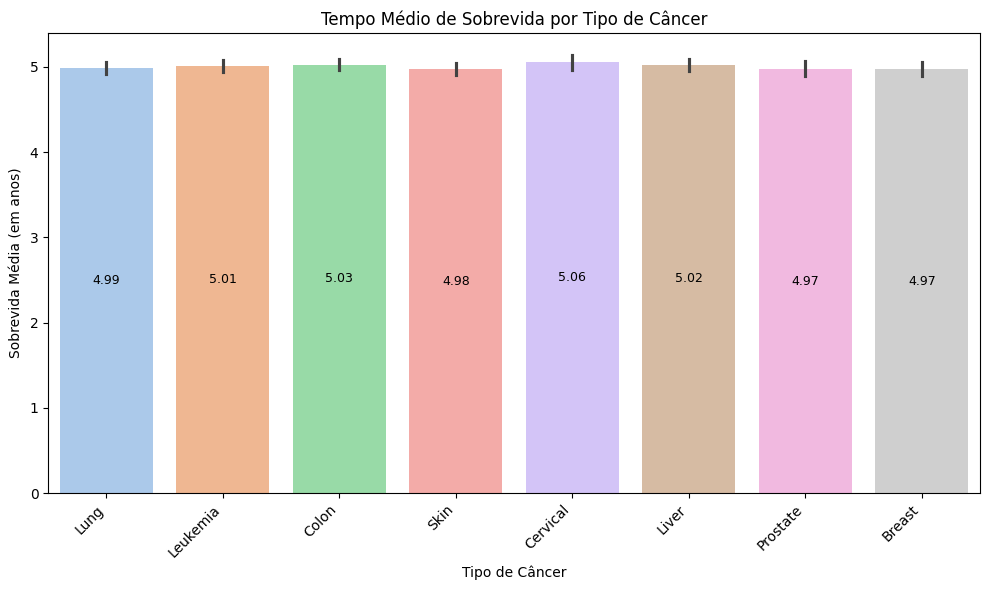

In [ ]:
# Sobrevida por tipo de cancer

# Plotar gr√°fico de barras
# Criar gr√°fico
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_cancer, x='Cancer_Type', y='Survival_Years', estimator='mean', palette='pastel')

# Adicionar r√≥tulos nas barras
for p in ax.patches:
    altura = p.get_height()
    ax.annotate(f'{altura:.2f}',
                (p.get_x() + p.get_width() / 2., altura * 0.5),
                ha='center', va='center', fontsize=9, color='black')

plt.title('Tempo M√©dio de Sobrevida por Tipo de C√¢ncer')
plt.ylabel('Sobrevida M√©dia (em anos)')
plt.xlabel('Tipo de C√¢ncer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Modelagem Preditiva para 2025


### Escolha da M√©trica de Avalia√ß√£o: MAE como Crit√©rio Principal

Como o objetivo central deste projeto √© **prever o n√∫mero total de casos de c√¢ncer por ano** ‚Äî valores agregados e cont√≠nuos ‚Äî a **m√©trica mais apropriada para sele√ß√£o do modelo preditivo** √© o **MAE (Erro Absoluto M√©dio)**. Um MAE menor significa que o modelo erra menos, em m√©dia.

O MAE oferece uma **medida direta da m√©dia dos erros absolutos**, permitindo compreender, de forma intuitiva, o desvio m√©dio entre os valores previstos e os observados. Essa caracter√≠stica √© especialmente relevante em contextos de **planejamento em sa√∫de p√∫blica**, onde o interesse est√° em saber **quantos casos a mais ou a menos** est√£o sendo projetados, sem que varia√ß√µes maiores sejam excessivamente penalizadas (como ocorre no RMSE, por exemplo).

Adicionalmente, o MAE √© **menos sens√≠vel a outliers**, o que o torna adequado para este conjunto de dados com distribui√ß√£o **anual relativamente est√°vel e sem grandes extremos**.

Dessa forma, neste projeto, o MAE foi adotado como **m√©trica principal de avalia√ß√£o de desempenho**, por representar com maior fidelidade o impacto pr√°tico dos erros de previs√£o. O **R¬≤** foi utilizado de forma **complementar**, fornecendo uma vis√£o sobre a **capacidade explicativa do modelo em rela√ß√£o √† variabilidade da s√©rie temporal**.


In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(result)
    print('Estat√≠stica ADF:', result[0])
    print('p-valor:', result[1])
    for key, value in result[4].items():
        print('Crit√©rio', key, ':', value)


test_stationarity(df_cancer['casos_por_ano'])

KeyError: 'casos_por_ano'

### Regress√£o Linear | Random Forest | XGBoost

In [ ]:
# Treinando, testando e avaliando os 3 modelos
# Agrupar n√∫mero de casos por ano
casos_por_ano = df_cancer.groupby('Year').size().reset_index(name='numero_de_casos')

# Separar treino e teste aleatoriamente por ano (70% treino, 30% teste)
X = casos_por_ano[['Year']]
y = casos_por_ano['numero_de_casos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Previs√£o para 2025
X_2025 = pd.DataFrame({'Year': [2025]})

# Treinar os modelos
modelo_lr = LinearRegression().fit(X_train, y_train)
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
modelo_xgb = XGBRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

# Previs√µes nos dados de teste
y_pred_lr = modelo_lr.predict(X_test)
y_pred_rf = modelo_rf.predict(X_test)
y_pred_xgb = modelo_xgb.predict(X_test)

# Previs√µes para 2025
prev_lr = modelo_lr.predict(X_2025)[0]
prev_rf = modelo_rf.predict(X_2025)[0]
prev_xgb = modelo_xgb.predict(X_2025)[0]

# Fun√ß√£o de avalia√ß√£o
def avaliar(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': mean_squared_error(y_true, y_pred) ** 0.5,
        'R¬≤': r2_score(y_true, y_pred)
    }

# Avalia√ß√£o dos modelos
resultados_modelos = {
    'Regress√£o Linear': avaliar(y_test, y_pred_lr),
    'Random Forest': avaliar(y_test, y_pred_rf),
    'XGBoost': avaliar(y_test, y_pred_xgb)
}

# Exibir previs√µes
print("\n Previs√£o para o n√∫mero de casos em 2025:")
print(f"‚Ä¢ Regress√£o Linear: {int(prev_lr)} casos")
print(f"‚Ä¢ Random Forest: {int(prev_rf)} casos")
print(f"‚Ä¢ XGBoost: {int(prev_xgb)} casos")

# Exibir m√©tricas
print("\n Avalia√ß√£o dos modelos nos dados de teste:")
for nome, metricas in resultados_modelos.items():
    print(f"\n{nome}")
    for met, val in metricas.items():
        print(f"{met}: {val:.2f}")



 Previs√£o para o n√∫mero de casos em 2025:
‚Ä¢ Regress√£o Linear: 4337 casos
‚Ä¢ Random Forest: 4362 casos
‚Ä¢ XGBoost: 4404 casos

 Avalia√ß√£o dos modelos nos dados de teste:

Regress√£o Linear
MAE: 64.38
RMSE: 75.46
R¬≤: -0.47

Random Forest
MAE: 51.52
RMSE: 58.51
R¬≤: 0.12

XGBoost
MAE: 55.67
RMSE: 56.38
R¬≤: 0.18


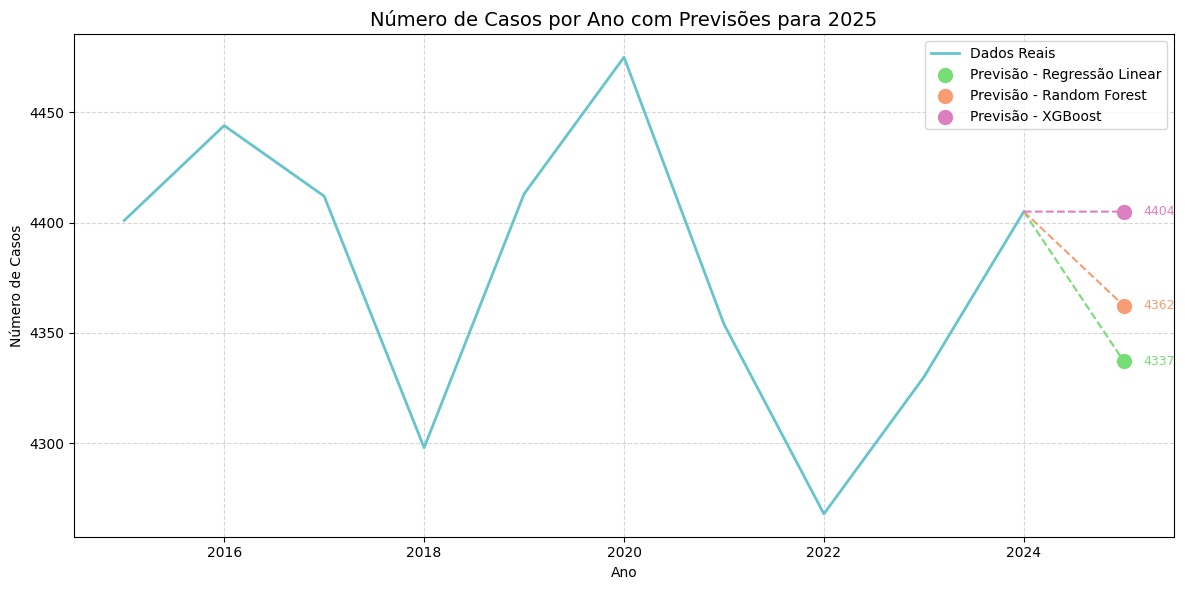

In [ ]:
# Gr√°fico com os dados reais e os valores previstos para cada modelo
plt.figure(figsize=(12, 6))

# Linha dos dados reais
plt.plot(casos_por_ano['Year'], casos_por_ano['numero_de_casos'], label='Dados Reais', color='#66c5cc', linewidth=2)

# √öltimo ponto conhecido (2024)
ultimo_ano = 2024
ultimo_valor = casos_por_ano[casos_por_ano['Year'] == ultimo_ano]['numero_de_casos'].values[0]

# Previs√µes dos modelos
plt.scatter(2025, prev_lr, color='#77DD77', s=100, label='Previs√£o - Regress√£o Linear')
plt.scatter(2025, prev_rf, color='#f89c74', s=100, label='Previs√£o - Random Forest')
plt.scatter(2025, prev_xgb, color='#dc7ec0', s=100, label='Previs√£o - XGBoost')

# Linhas conectando o √∫ltimo valor real √†s previs√µes
plt.plot([2024, 2025], [ultimo_valor, prev_lr], color='#77DD77', linestyle='--')
plt.plot([2024, 2025], [ultimo_valor, prev_rf], color='#f89c74', linestyle='--')
plt.plot([2024, 2025], [ultimo_valor, prev_xgb], color='#dc7ec0', linestyle='--')

# Anota√ß√µes nos pontos de previs√£o
plt.text(2025 + 0.2, prev_lr, f'{int(prev_lr)}', color='#77DD77', va='center', fontsize=9)
plt.text(2025 + 0.2, prev_rf, f'{int(prev_rf)}', color='#f89c74', va='center', fontsize=9)
plt.text(2025 + 0.2, prev_xgb, f'{int(prev_xgb)}', color='#dc7ec0', va='center', fontsize=9)

# Personaliza√ß√£o do gr√°fico
plt.title('N√∫mero de Casos por Ano com Previs√µes para 2025', fontsize=14)
plt.xlabel('Ano')
plt.ylabel('N√∫mero de Casos')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Criando DataFrame com os resultados e elencando conforme performance
df_resultados = pd.DataFrame(resultados_modelos).T  # .T = transpor
df_resultados = df_resultados.round(2)

# Adicionar coluna com "ranking" por MAE (quanto menor, melhor)
df_resultados['Ranking_MAE'] = df_resultados['MAE'].rank(method='min')

# Determinar o melhor modelo (menor MAE)
melhor_modelo = df_resultados.sort_values('MAE').index[0]

# Exibir tabela completa
print("\n Compara√ß√£o das M√©tricas dos Modelos:")
display(df_resultados)

# Exibir escolha final
print(f"\nüèÜ Melhor modelo com base na menor MAE: {melhor_modelo}")



 Compara√ß√£o das M√©tricas dos Modelos:


MAE   RMSE    R¬≤  Ranking_MAE
Regress√£o Linear  64.38  75.46 -0.47          3.0
Random Forest     51.52  58.51  0.12          1.0
XGBoost           55.67  56.38  0.18          2.0


üèÜ Melhor modelo com base na menor MAE: Random Forest


## Previs√£o com c√°lculo estat√≠stico para 2025

Nesta se√ß√£o, realizamos uma proje√ß√£o do n√∫mero de casos de c√¢ncer para os pr√≥ximos anos (2025‚Äì2030) utilizando uma abordagem estat√≠stica simples baseada na evolu√ß√£o hist√≥rica anual. Calculamos o crescimento m√©dio e o desvio padr√£o dos casos entre 2015 e 2024, e aplicamos um intervalo de confian√ßa de 95% (z-score = 1.96) para estimar a incerteza da proje√ß√£o. Essa metodologia assume que os dados seguem um padr√£o aproximadamente normal e est√°vel ao longo do tempo. O resultado √© apresentado em um gr√°fico que mostra os valores hist√≥ricos, os valores projetados e a faixa de incerteza esperada. Essa visualiza√ß√£o ajuda a contextualizar n√£o apenas a tend√™ncia futura, mas tamb√©m o grau de confiabilidade das estimativas realizadas, sendo uma ferramenta √∫til para an√°lise de risco e planejamento de pol√≠ticas p√∫blicas.

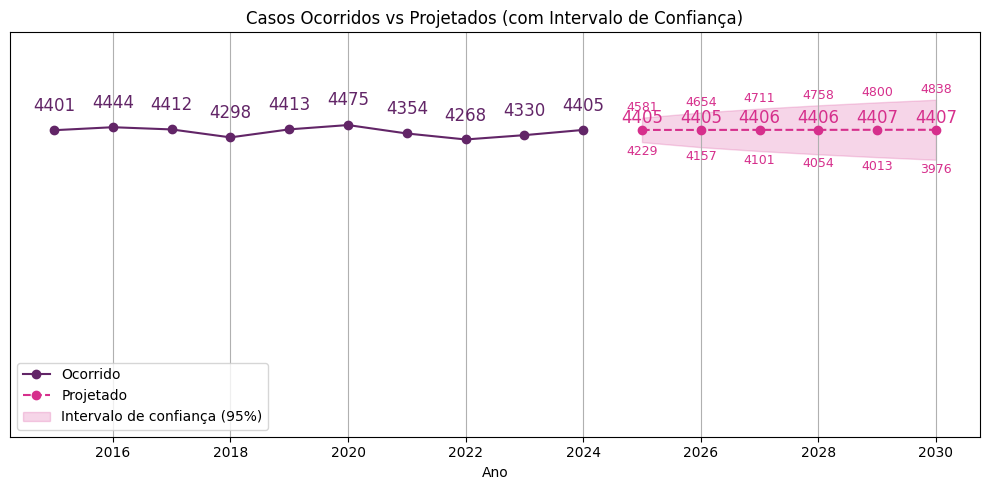

In [ ]:
# 1. Agrupar total de casos por ano
total_por_ano = df_cancer.groupby('Year').size()

# 2. Calcular o crescimento absoluto de casos ano a ano
crescimento_anual = total_por_ano.diff().dropna()

# 3. Calcular a m√©dia e o desvio padr√£o do crescimento
crescimento_medio = crescimento_anual.mean()
std_crescimento = crescimento_anual.std()

# 4. Proje√ß√£o com intervalo de confian√ßa
z = 1.96  # Z-score para 95% de confian√ßa (assumindo distribui√ß√£o normal)
ultimo_valor = total_por_ano.loc[2024]  # √∫ltimo valor conhecido
anos_futuros = range(2025, 2031)  # anos que queremos projetar
projecao = []  # lista para armazenar os resultados

for i, year in enumerate(anos_futuros, start=1):
    # Valor esperado baseado na m√©dia de crescimento
    esperado = ultimo_valor + crescimento_medio

    # Erro padr√£o acumulado (cresce com o tempo)
    erro_padrao = std_crescimento * np.sqrt(i)

    # C√°lculo do intervalo de confian√ßa (95%)
    intervalo_inferior = esperado - z * erro_padrao
    intervalo_superior = esperado + z * erro_padrao

    # Armazenar proje√ß√£o
    projecao.append((year, int(esperado), intervalo_inferior, intervalo_superior))

    # Atualizar √∫ltimo valor para projetar o pr√≥ximo
    ultimo_valor = esperado

# 5. Criar DataFrame com dados hist√≥ricos + projetados
projecao_df = pd.concat([
    total_por_ano[total_por_ano.index <= 2024].rename('casos').to_frame(),
    pd.DataFrame(projecao, columns=['ano', 'casos', 'lower', 'upper']).set_index('ano')
])

# 6. Adicionar tag para facilitar visualiza√ß√£o
projecao_df['tag'] = projecao_df.index.to_series().apply(
    lambda x: 'ocorrido' if x <= 2024 else 'projetado'
)

# 7. Separar hist√≥rico vs. previs√£o
ocorrido = projecao_df[projecao_df['tag'] == 'ocorrido']
projetado = projecao_df[projecao_df['tag'] == 'projetado']

# 8. Visualiza√ß√£o
plt.figure(figsize=(10, 5))

# Linhas principais
plt.plot(ocorrido.index, ocorrido['casos'], label='Ocorrido', color='#622567', marker='o')
plt.plot(projetado.index, projetado['casos'], label='Projetado', color='#D62F8C', linestyle='--', marker='o')

# √Årea de intervalo de confian√ßa
plt.fill_between(
    projetado.index,
    projetado['lower'],
    projetado['upper'],
    color='#D62F8C',
    alpha=0.2,
    label='Intervalo de confian√ßa (95%)'
)

# Adicionar r√≥tulos para os valores observados
for i, v in ocorrido['casos'].items():
    plt.text(i, v * 1.05, str(v), ha='center', va='bottom', fontsize=12, color='#622567')

# Adicionar r√≥tulos para os valores projetados e seus intervalos
for i in projetado.index:
    valor = projetado.loc[i, 'casos']
    lower = projetado.loc[i, 'lower']
    upper = projetado.loc[i, 'upper']

    plt.text(i, valor * 1.01, f'{int(valor)}', ha='center', va='bottom', fontsize=12, color='#D62F8C')
    plt.text(i, lower * 0.99, f'{int(lower)}', ha='center', va='top', fontsize=9, color='#D62F8C')
    plt.text(i, upper * 1.01, f'{int(upper)}', ha='center', va='bottom', fontsize=9, color='#D62F8C')

# Ajustes finais do gr√°fico
max_val = max(projetado['upper'].max(), ocorrido['casos'].max())
plt.ylim(0, max_val * 1.2)
plt.title('Casos Ocorridos vs Projetados (com Intervalo de Confian√ßa)')
plt.xlabel('Ano')
plt.ylabel('')
plt.yticks([])
plt.legend()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


##Impacto das vari√°veis

###Fatores de Risco

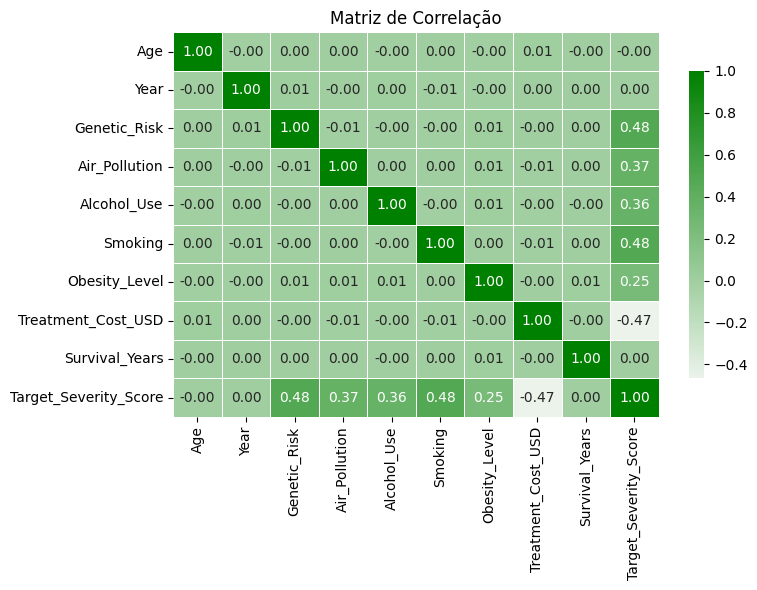


Correla√ß√£o com a vari√°vel Target_Severity_Score:
Target_Severity_Score    1.000000
Smoking                  0.483867
Genetic_Risk             0.478961
Air_Pollution            0.366364
Alcohol_Use              0.362806
Obesity_Level            0.252624
Survival_Years           0.002405
Year                     0.001451
Age                     -0.002181
Treatment_Cost_USD      -0.466352
Name: Target_Severity_Score, dtype: float64


In [ ]:
# Matriz de correla√ß√£o
# Seleciona colunas num√©ricas
num_cols = ['Age', 'Year', 'Genetic_Risk', 'Air_Pollution', 'Alcohol_Use',
            'Smoking', 'Obesity_Level', 'Treatment_Cost_USD', 'Survival_Years', 'Target_Severity_Score']

df_num = df_cancer[num_cols]

pastel_cmap = sns.light_palette("green", as_cmap=True)

# Matriz de correla√ß√£o
plt.figure(figsize=(8, 6))
sns.heatmap(
    df_num.corr(),
    annot=True,
    cmap=pastel_cmap,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Matriz de Correla√ß√£o")
plt.tight_layout()
plt.show()

# Correla√ß√£o com a vari√°vel Target_Severity_Score
print("\nCorrela√ß√£o com a vari√°vel Target_Severity_Score:")
print(df_num.corr()['Target_Severity_Score'].sort_values(ascending=False))


###Import√¢ncia das vari√°veis

Comparativo de Import√¢ncia entre Random Forest e XGBoost:
             Vari√°vel  Import√¢ncia_RF  Import√¢ncia_XGB
4             Smoking          0.2339           0.2250
1        Genetic_Risk          0.2295           0.2100
6  Treatment_Cost_USD          0.2141           0.2105
3         Alcohol_Use          0.1292           0.1396
2       Air_Pollution          0.1285           0.1376
5       Obesity_Level          0.0581           0.0763
7      Survival_Years          0.0033           0.0005
0                 Age          0.0033           0.0004


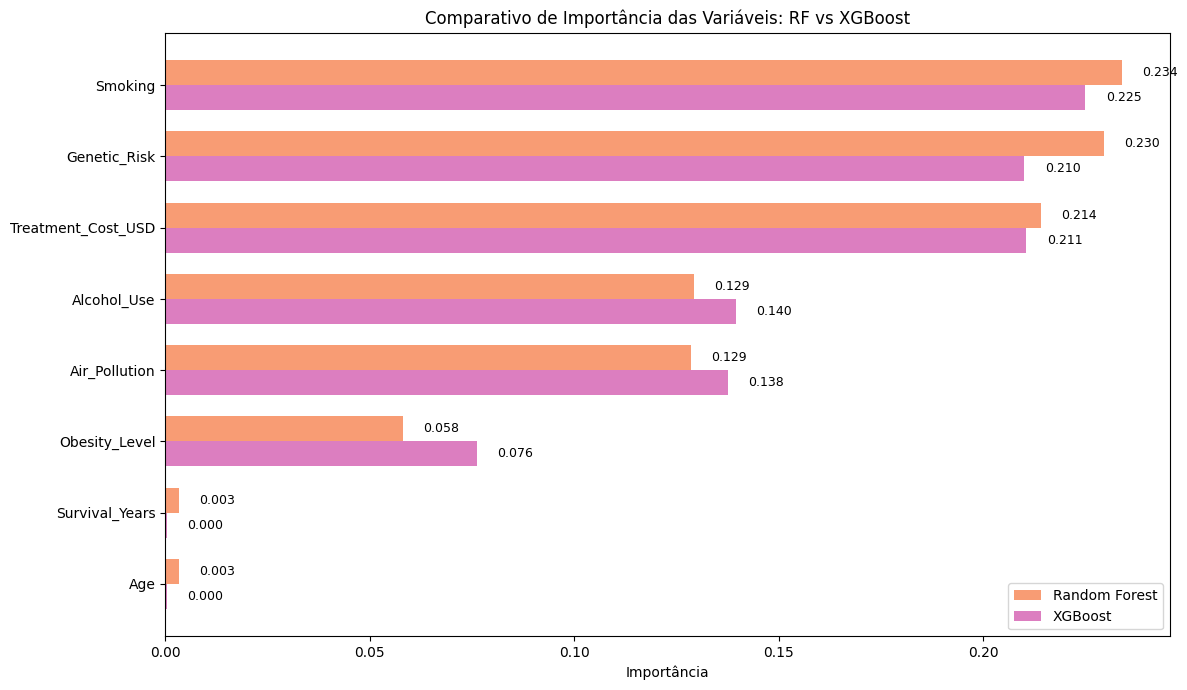

In [ ]:
# Importancia das vari√°veis nos modelos Random Forest e XGBoost
# Vari√°veis preditoras (num√©ricas)
colunas = ['Age','Genetic_Risk', 'Air_Pollution', 'Alcohol_Use',
            'Smoking', 'Obesity_Level','Treatment_Cost_USD', 'Survival_Years',
]

X = df_cancer[colunas]
y = df_cancer['Target_Severity_Score']

# Modelos
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

rf_model.fit(X, y)
xgb_model.fit(X, y)

# Import√¢ncia das vari√°veis
import_rf = pd.DataFrame({
    'Vari√°vel': colunas,
    'Import√¢ncia_RF': rf_model.feature_importances_
})

import_xgb = pd.DataFrame({
    'Vari√°vel': colunas,
    'Import√¢ncia_XGB': xgb_model.feature_importances_
})

# Mesclar resultados
comparativo = pd.merge(import_rf, import_xgb, on='Vari√°vel')
comparativo = comparativo.sort_values(by='Import√¢ncia_RF', ascending=False)

# Exibir tabela
print("Comparativo de Import√¢ncia entre Random Forest e XGBoost:")
print(comparativo.round(4))

# Plotar gr√°fico comparativo com cores past√©is e r√≥tulos
plt.figure(figsize=(12, 7))
bar_width = 0.35
index = range(len(comparativo))

# Cores past√©is
cor_rf = '#f89c74'
cor_xgb = '#dc7ec0'

# Barras
bars_rf = plt.barh(index, comparativo['Import√¢ncia_RF'], height=bar_width, label='Random Forest', color=cor_rf)
bars_xgb = plt.barh([i + bar_width for i in index], comparativo['Import√¢ncia_XGB'], height=bar_width, label='XGBoost', color=cor_xgb)

# R√≥tulos nas barras
for i, bar in enumerate(bars_rf):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.3f}', va='center', fontsize=9)

for i, bar in enumerate(bars_xgb):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.3f}', va='center', fontsize=9)

# Eixo e legenda
plt.yticks([i + bar_width / 2 for i in index], comparativo['Vari√°vel'])
plt.xlabel('Import√¢ncia')
plt.title('Comparativo de Import√¢ncia das Vari√°veis: RF vs XGBoost')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

##Existe diferen√ßa significativa entre a incid√™ncia de cada tipo de c√¢ncer quando comparamos homens e mulheres?

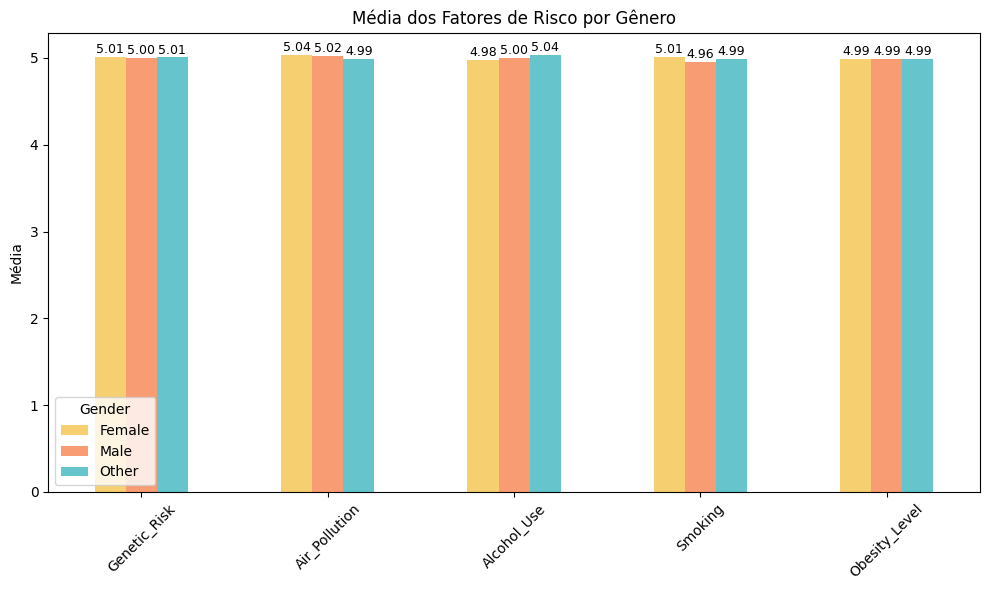

In [ ]:
# Gr√°fico comparativo da m√©dia dos fatores de risco por g√™nero
cores_pasteis = ['#f6cf71', '#f89c74', '#66c5cc']

cols_risco = ["Genetic_Risk", "Air_Pollution", "Alcohol_Use", "Smoking", "Obesity_Level"]

mean_by_gender = df_cancer[df_cancer["Gender"].isin(["Male", "Female", "Other"])].groupby("Gender")[cols_risco].mean().T

ax = mean_by_gender.plot(
    kind="bar",
    figsize=(10, 6),
    color=cores_pasteis,
    title="M√©dia dos Fatores de Risco por G√™nero"
)

plt.ylabel("M√©dia")
plt.xticks(rotation=45)
plt.tight_layout()

# Adicionar r√≥tulos em cima das barras
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 0.01,
        f'{height:.2f}',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.show()

In [ ]:
#Tipos de cancer e genero

contingencia = pd.crosstab(df_cancer['Cancer_Type'], df_cancer['Gender'])
print(contingencia)


Gender       Female  Male  Other
Cancer_Type                     
Breast         2051    21   2058
Cervical       2160     0   2034
Colon          2108  2147   2121
Leukemia       2081  2092   2093
Liver          2064  2091   2094
Lung           2067  2103   1989
Prostate          0  2138   2057
Skin           2065  2117   2049


In [ ]:
# Teste do Qui-quadrado para responder: A distribui√ß√£o dos tipos de c√¢ncer varia entre g√™neros?
# Esse teste verifica se existe associa√ß√£o entre duas vari√°veis categ√≥ricas (tipo de c√¢ncer e g√™nero)
chi2, p, dof, expected = chi2_contingency(contingencia)

print(f'Estat√≠stica qui-quadrado: {chi2:.4f}')
print(f'Valor p: {p:.4f}')

# Interpreta√ß√£o do resultado
if p < 0.05:
    print("\n‚úÖ Como o valor p √© menor que 0.05, rejeitamos a hip√≥tese nula.")
    print("‚û°Ô∏è H√° evid√™ncias estat√≠sticas de que o tipo de c√¢ncer est√° associado ao g√™nero do paciente.")
    print("   Ou seja, a distribui√ß√£o dos tipos de c√¢ncer varia entre homens e mulheres.")
else:
    print("\n‚ùå Como o valor p √© maior que 0.05, n√£o rejeitamos a hip√≥tese nula.")
    print("‚û°Ô∏è N√£o h√° evid√™ncias suficientes para afirmar que existe associa√ß√£o entre o tipo de c√¢ncer e o g√™nero.")
    print("   As vari√°veis podem ser consideradas estatisticamente independentes.")

Estat√≠stica qui-quadrado: 6069.0336
Valor p: 0.0000

‚úÖ Como o valor p √© menor que 0.05, rejeitamos a hip√≥tese nula.
‚û°Ô∏è H√° evid√™ncias estat√≠sticas de que o tipo de c√¢ncer est√° associado ao g√™nero do paciente.
   Ou seja, a distribui√ß√£o dos tipos de c√¢ncer varia entre homens e mulheres.


# Conclus√£o

Este projeto teve como objetivo conduzir uma an√°lise explorat√≥ria e preditiva sobre a evolu√ß√£o global do c√¢ncer entre os anos de 2015 e 2024, utilizando um conjunto de dados sint√©ticos com informa√ß√µes cl√≠nicas, demogr√°ficas e comportamentais de pacientes.

---

## An√°lise Explorat√≥ria e Visualiza√ß√µes

- **Pa√≠ses com maior n√∫mero de casos**: Austr√°lia, Reino Unido, Estados Unidos, √çndia e Alemanha.
- **Tend√™ncia temporal**: crescimento moderado no n√∫mero de casos entre 2015 e 2024.
- **Distribui√ß√£o por vari√°veis**: idade, g√™nero e tipo de c√¢ncer revelaram padr√µes relativamente homog√™neos, com pequenas varia√ß√µes.
- **An√°lise de variabilidade**: identifica√ß√£o de outliers e correla√ß√µes com boxplots e mapas de calor.

---

## Modelagem Preditiva

- Modelos testados: Regress√£o Linear, Random Forest e XGBoost.
- Divis√£o dos dados:
  - Treino: 70% de cada ano
  - Teste: 30% de cada ano
- **Melhor modelo**: Random Forest, com menor MAE e RMSE.
- **Previs√µes para 2025**:
  - Random Forest: **4.362 casos**
  - Estimativa estat√≠stica: **4.405 casos**

---

## Import√¢ncia das Vari√°veis (Random Forest e XGBoost)

Principais fatores de risco associados √† severidade dos casos:

- Fumo  
- Risco gen√©tico  
- Custo do tratamento  
- Consumo de √°lcool  
- Polui√ß√£o do ar  
- Obesidade

Essas vari√°veis devem ser **priorizadas em campanhas de preven√ß√£o e pol√≠ticas de sa√∫de p√∫blica**.

---

## Diferen√ßas entre G√™neros

- **An√°lise visual**: pequenas varia√ß√µes nos tipos de c√¢ncer mais incidentes entre homens e mulheres.
- **Teste do qui-quadrado**: valor-p < 0.05 ‚Üí **diferen√ßas estatisticamente significativas**.
  - Alguns c√¢nceres s√£o fortemente associados ao sexo biol√≥gico (ex: mama, pr√≥stata).
- Nos demais tipos, **n√£o h√° evid√™ncias robustas de desigualdade de incid√™ncia por g√™nero**.

---

## Propostas de Interven√ß√£o Baseadas nos Dados da Organiza√ß√£o Mundial da Sa√∫de (OMS)

### 1. Pa√≠ses de Baixo e M√©dio IDH  
*Exemplos: Eti√≥pia, Z√¢mbia, Malaui, Tanz√¢nia*

**A√ß√µes recomendadas**:

- **Vacina√ß√£o contra HPV**: essencial para preven√ß√£o do c√¢ncer do colo do √∫tero.
- **Programas de rastreamento (Papanicolau ou teste de HPV)**.
- **Amplia√ß√£o do acesso ao tratamento oncol√≥gico b√°sico**.
- **Campanhas educativas** sobre sintomas e preven√ß√£o.

---

### 2. Pa√≠ses de Alto IDH  
*Exemplos: Estados Unidos, Reino Unido, Austr√°lia*

**A√ß√µes recomendadas**:

- Redu√ß√£o do tabagismo e da polui√ß√£o do ar.
- Promo√ß√£o de alimenta√ß√£o saud√°vel e atividade f√≠sica.
- Redu√ß√£o do consumo de √°lcool.
- Combate √† obesidade.
- Rastreamento regular: mamografia, colonoscopia, exames de pr√≥stata.
- Monitoramento de c√¢nceres de in√≠cio precoce em adultos jovens.

---

### 3. Popula√ß√µes Vulner√°veis Dentro de Qualquer Pa√≠s

**Grupos priorit√°rios**:

- Mulheres em situa√ß√£o de pobreza
- Popula√ß√µes ind√≠genas ou rurais
- Jovens adultos (30‚Äì40 anos)

**Medidas necess√°rias**:

- Acesso a exames preventivos e vacina√ß√£o.
- Expans√£o da rede de diagn√≥stico precoce e tratamento.
- Inclus√£o de jovens adultos em diretrizes de rastreamento.

---

## Considera√ß√µes Finais

A an√°lise revelou padr√µes relevantes e consistentes com os dados da OMS, al√©m de evidenciar lacunas em rela√ß√£o √† realidade global. Portanto, as **estrat√©gias de preven√ß√£o e controle do c√¢ncer devem**:

- **Considerar o n√≠vel de desenvolvimento de cada pa√≠s**.
- **Adaptar-se √†s caracter√≠sticas epidemiol√≥gicas regionais**.
- **Priorizar popula√ß√µes mais vulner√°veis**.

Com base em dados e interven√ß√µes direcionadas, √© poss√≠vel reduzir de forma significativa os casos e mortes por c√¢ncer em escala global.

---
